# PREDICTING FUTURE BEHAVIOUR OF S&P 500 STOCK MARKET INDEX
# A machine learning-based approach leveraging MarketPsych sentiment indicators


## Index
* [1. Data loading and some EDA](#1.-Data-loading-and-some-EDA)
    * [Sentiment indicators](#Sentiment-indicators)
    * [Market data](#Market-data)
* [2. Data preparation](#2.-Data-preparation)
    * [Missing values](#Missing-values)
    * [Transformations](#Transformations)
    * [Smoothing](#Smoothing)
    * [Feature Engineering](#Feature-Engineering)
        * [PCA](#PCA)
        * [Technical indicators](#Technical-indicators)
    * [Labeling target variable](#Labeling-target-variable)
* [3. Model](#3.-Model)

In [1]:
import mlfinlab as mlfin
import pandas as pd
import pandas_datareader as pdr
import pandas_profiling as pf
import numpy as np
from yahoo_finance import Share
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, HBox, Label
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from plotly.validators.scatter.marker import SymbolValidator
import warnings
from plotly.subplots import make_subplots
import missingno as msno
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats
import pywt
import sys
from ta.momentum import RSIIndicator, StochasticOscillator, WilliamsRIndicator, ROCIndicator
from ta.trend import MACD, ADXIndicator
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier, plot_importance, plot_tree
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import os

#def enable_plotly_in_cell():
#    import IPython
#   from plotly.offline import init_notebook_mode
#    
#    display(IPython.core.display.HTML('''<script src="/static/components/requirejs/require.js"></script>'''))
#    init_notebook_mode(connected=False)

init_notebook_mode(connected=True)
sns.set_context('notebook', rc={"axes.titlesize":14,"axes.labelsize":13})
#sns.set(rc = {'figure.figsize': (15, 4)})
sns.set_style('white')
%matplotlib inline
bbva = ['#004481','#2DCCCD', '#D8BE75','#1973B8', '#5BBEFF', '#F7893B', '#02A5A5', '#48AE64', '#F8CD51', '#F78BE8'];
sns.set_palette(bbva);

## 1. Data loading and some EDA

### Sentiment indicators

In [2]:
def load_data(data='countries', data_type='News_Social', asset_code_id='US'):
    dirs = os.listdir('./')
    if data == 'countries':
        dataset = pd.read_csv('COU_CARGA_INICIAL.csv', sep=';')
        dataset = dataset[dataset.date <= '2020-03-30']
        for dire in dirs:
            if ('COU' in dire) and (dire != 'COU_CARGA_INICIAL.csv'):
                new_month = pd.read_csv(dire, delimiter='\t')
                if len(new_month.columns) == 1:
                    new_month = pd.read_csv(dire, delimiter=';')
                if 'date' not in new_month.columns:
                    new_month['date'] = new_month.id.apply(lambda x: x[3:13])
                if 'asset_code_id' not in new_month.columns:
                    new_month['asset_code_id'] = new_month.assetCode
                if 'data_type' not in new_month.columns:
                    new_month['data_type'] = new_month.dataType
                if 'id_refinitiv' not in new_month.columns:
                    new_month['id_refinitiv'] = new_month.id
                if 'system_version' not in new_month.columns:
                    new_month['system_version'] = new_month.systemVersion
                if 'date_audit_laod' not in new_month.columns:
                    new_month['date_audit_laod'] = 'NA'
                if 'process_audit_load' not in new_month.columns:
                    new_month['process_audit_load'] = 'NA'
                new_month = new_month[dataset.columns]
                dataset = pd.concat([dataset, new_month], ignore_index=True)
        sufix = '_USA'
        
    elif data == 'currencies':
        dataset = pd.read_csv('CUR_CARGA_INICIAL.csv', sep=';')
        dataset = dataset[dataset.date <= '2020-03-30']
        for dire in dirs:
            if ('CUR' in dire) and (dire != 'CUR_CARGA_INICIAL.csv'):
                new_month = pd.read_csv(dire, delimiter='\t')
                if len(new_month.columns) == 1:
                    new_month = pd.read_csv(dire, delimiter=';')
                if 'date' not in new_month.columns:
                    new_month['date'] = new_month.id.apply(lambda x: x[3:13])
                if 'asset_code_id' not in new_month.columns:
                    new_month['asset_code_id'] = new_month.assetCode
                if 'data_type' not in new_month.columns:
                    new_month['data_type'] = new_month.dataType
                if 'id_refinitiv' not in new_month.columns:
                    new_month['id_refinitiv'] = new_month.id
                if 'system_version' not in new_month.columns:
                    new_month['system_version'] = new_month.systemVersion
                if 'date_audit_laod' not in new_month.columns:
                    new_month['date_audit_laod'] = 'NA'
                if 'process_audit_load' not in new_month.columns:
                    new_month['process_audit_load'] = 'NA'
                new_month = new_month[dataset.columns]
                dataset = pd.concat([dataset, new_month], ignore_index=True)
        sufix = '_USD'
        
    elif data == 'companies':
        dataset = pd.read_csv('CMPNY_GRP_CARGA_INICIAL.csv', sep=';')
        dataset = dataset[dataset.date <= '2020-03-30']
        for dire in dirs:
            if ('CMPNY' in dire) and (dire != 'CMPNY_GRP_CARGA_INICIAL.csv'):
                new_month = pd.read_csv(dire, delimiter='\t')
                if len(new_month.columns) == 1:
                    new_month = pd.read_csv(dire, delimiter=';')
                if 'date' not in new_month.columns:
                    new_month['date'] = new_month.id.apply(lambda x: x[3:13])
                if 'asset_code_id' not in new_month.columns:
                    new_month['asset_code_id'] = new_month.assetCode
                if 'data_type' not in new_month.columns:
                    new_month['data_type'] = new_month.dataType
                if 'id_refinitiv' not in new_month.columns:
                    new_month['id_refinitiv'] = new_month.id
                if 'system_version' not in new_month.columns:
                    new_month['system_version'] = new_month.systemVersion
                if 'date_audit_laod' not in new_month.columns:
                    new_month['date_audit_laod'] = 'NA'
                if 'process_audit_load' not in new_month.columns:
                    new_month['process_audit_load'] = 'NA'
                new_month = new_month[dataset.columns]
                dataset = pd.concat([dataset, new_month], ignore_index=True)
        sufix = '_US500'

    dataset = dataset[(dataset.data_type == data_type) & 
                       (dataset.asset_code_id == asset_code_id) &
                       (dataset.date >= '2000-01-01')].sort_values(by='date')
    
    dataset['Date'] = pd.to_datetime(dataset.date)
    dataset.set_index('Date', inplace=True)
    dataset.drop('date', axis=1, inplace=True)
    dataset.columns = [col + sufix for col in dataset.columns]
    
    return dataset

In [3]:
# Countries info
countries = load_data(data='countries', data_type='News_Social', asset_code_id='US')
pf.ProfileReport(countries, explorative=True, minimal=True)

In [4]:
countries.describe()

stockIndexBuzz_USA   bondBuzz_USA  ratesBuzz_USA  \
count         7548.000000    7548.000000    7548.000000   
mean          7766.818243    5018.980896    3059.338103   
std           7423.268580    5703.682036    3620.876817   
min             59.200000      38.000000      25.000000   
25%           2221.575000    1746.250000     634.875000   
50%           5814.000000    3864.050000    1903.000000   
75%          11281.950000    6928.450000    4178.750000   
max         134839.000000  126062.900000   45542.500000   

       stockIndexSentiment_USA  stockIndexOptimism_USA  stockIndexTrust_USA  \
count              7548.000000             7548.000000          7546.000000   
mean                 -0.045077               -0.004602             0.003662   
std                   0.146176                0.026762             0.005205   
min                  -0.466583               -0.212583            -0.035411   
25%                  -0.154254               -0.019818             0.000708   
50%                  -0.042142               -0.004615             0.002594   
75%                   0.066406                0.010433             0.005566   
max                   0.390025                0.231104             0.045873   

       stockIndexFear_USA  stockIndexStress_USA  stockIndexSurprise_USA  \
count         7521.000000           7548.000000             7455.000000   
mean             0.011027              0.046969                0.004845   
std              0.007044              0.015133                0.004011   
min             -0.004999              0.007194               -0.009065   
25%              0.006011              0.036367                0.002423   
50%              0.009419              0.044996                0.003920   
75%              0.014252              0.055582                0.006144   
max              0.068737              0.158899                0.072478   

       stockIndexUncertainty_USA  ...  bondUncertainty_USA  bondDefault_USA  \
count                7548.000000  ...          7540.000000      7487.000000   
mean                    0.029227  ...             0.020278         0.018076   
std                     0.027715  ...             0.008642         0.012289   
min                     0.001890  ...            -0.014634        -0.118110   
25%                     0.016069  ...             0.014702         0.010157   
50%                     0.021073  ...             0.018928         0.015456   
75%                     0.029007  ...             0.024224         0.022533   
max                     0.267216  ...             0.098859         0.125559   

       bondPriceDirection_USA  bondPriceForecast_USA  bondVolatility_USA  \
count             7543.000000            7215.000000         7538.000000   
mean                 0.008856               0.000788            0.028208   
std                  0.030095               0.004918            0.011702   
min                 -0.142631              -0.054225           -0.007491   
25%                 -0.006501              -0.001321            0.020393   
50%                  0.006400               0.000647            0.025982   
75%                  0.023477               0.002868            0.033606   
max                  0.189027               0.045312            0.153226   

       centralBank_USA  debtDefault_USA  interestRates_USA  \
count      7548.000000      7548.000000        7416.000000   
mean          0.582781         0.253980           0.026239   
std           0.131323         0.132086           0.038675   
min           0.056878         0.013831          -0.156575   
25%           0.498940         0.150913           0.004769   
50%           0.595217         0.235606           0.015038   
75%           0.678474         0.339387           0.036436   
max           0.892727         0.835544           0.257800   

       interestRatesForecast_USA  monetaryPolicyLooseVsTight_USA  
count                6770.000000                     7432.000000

In [5]:
# Currencies info
currencies = load_data(data='currencies', data_type='News_Social', asset_code_id='USD')
pf.ProfileReport(currencies, minimal=True)

In [6]:
currencies.describe()

buzz_USD  sentiment_USD  optimism_USD      joy_USD  loveHate_USD  \
count   7548.000000    7547.000000   7527.000000  6838.000000   6917.000000   
mean    6291.483148      -0.048832     -0.008621     0.003236      0.002251   
std     5878.626096       0.076155      0.025536     0.003636      0.003705   
min        1.000000      -0.405405     -0.238095    -0.009083     -0.031250   
25%     1364.325000      -0.097635     -0.020774     0.001253      0.000934   
50%     4119.500000      -0.047602     -0.007243     0.002205      0.001759   
75%    10248.975000      -0.000846      0.005401     0.003954      0.002925   
max    46081.300000       0.500000      0.242424     0.061958      0.134658   

         trust_USD    anger_USD  conflict_USD     fear_USD    gloom_USD  ...  \
count  7462.000000  6926.000000   7526.000000  7335.000000  7481.000000  ...   
mean      0.002421     0.002856      0.002425     0.008548     0.021687  ...   
std       0.005628     0.003006      0.013154     0.006322     0.010245  ...   
min      -0.140000    -0.005576     -0.177778    -0.044444    -0.088889  ...   
25%       0.000000     0.001248     -0.003665     0.004441     0.015184  ...   
50%       0.001826     0.002090      0.001981     0.007153     0.019908  ...   
75%       0.004299     0.003479      0.007852     0.011070     0.025938  ...   
max       0.055556     0.073132      0.208333     0.099196     0.121131  ...   

       emotionVsFact_USD  marketRisk_USD  longShort_USD  \
count        7548.000000     7544.000000    7459.000000   
mean            0.248426        0.035269       0.002033   
std             0.068880        0.025429       0.008083   
min            -0.104673       -0.154762      -0.111111   
25%             0.207735        0.021048      -0.001442   
50%             0.243211        0.035822       0.002030   
75%             0.281525        0.050797       0.005407   
max             1.000000        0.200000       0.173913   

       longShortForecast_USD  priceDirection_USD  priceForecast_USD  \
count            6982.000000         7545.000000        7502.000000   
mean                0.000402            0.019455           0.000849   
std                 0.003613            0.045363           0.010810   
min                -0.111111           -0.195946          -0.120690   
25%                -0.000481           -0.010270          -0.003578   
50%                 0.000331            0.018441           0.001145   
75%                 0.001226            0.047655           0.005700   
max                 0.133333            0.400000           0.400000   

       volatility_USD  carryTrade_USD  currencyPegInstability_USD  \
count     7471.000000     2034.000000                 4162.000000   
mean         0.025825        0.000723                    0.000541   
std          0.011157        0.001348                    0.002789   
min         -0.009539       -0.000789                   -0.025316   
25%          0.019311        0.000121                   -0.000149   
50%          0.025046        0.000292                    0.000148   
75%          0.030945        0.000736                    0.000728   
max          0.500000        0.018123                    0.047619   

       priceMomentum_USD  
count        7443.000000  
mean            0.005659  
std             0.008824  
min            -0.060606  
25%             0.000765  
50%             0.005420  
75%             0.010466  
max             0.100000  

[8 rows x 25 columns]

In [7]:
companies = load_data(data='companies', data_type='News_Social', asset_code_id='MPTRXUS500')
pf.ProfileReport(companies, minimal=True)

### Market data

In [8]:
start_date = datetime(1999, 11, 30)
end_date = datetime(2020, 8, 31)

# SP500 Yahoo Finance
sp500_yahoo = pdr.get_data_yahoo(symbols='^GSPC', start=start_date, end=end_date)
sp500_yahoo = sp500_yahoo.asfreq('D', method=None) # hay días que no están registrados, generamos días
display(sp500_yahoo.head())

# Adding return and volatility just for plotting (as this has to be calculated separately in train and test)
original_columns = sp500_yahoo.columns
sp500_yahoo['Daily Return'] = sp500_yahoo['Adj Close'].pct_change(periods=1)*100
sp500_yahoo['Daily Volatility'] = sp500_yahoo['Daily Return'].ewm(span=30).std() # exponential moving std

def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)+1):
        yield start_date + timedelta(n)

weekend = [6, 7]
weekdays = []
for dt in daterange(start_date, end_date):
    if dt.isoweekday() not in weekend:
        weekdays.append(dt.strftime('%Y-%m-%d'))

# Nos quedamos solo con los días de la semana y eliminamos los fines de semana 
sp500_yahoo = sp500_yahoo[sp500_yahoo.index.isin(weekdays)]

# Expected Volatility of SP500
#vix = pdr.get_data_yahoo(symbols='^VIX', start=start_date, end=end_date)
#vix = vix.asfreq('D', method='ffill')
#display(vix.head())

# añadimos vix a sp500
#sp500['VIX Close'] = vix.Close

High          Low         Open        Close        Volume  \
Date                                                                           
1999-11-30  1410.589966  1386.949951  1407.829956  1388.910034  9.515000e+08   
1999-12-01  1400.119995  1387.380005  1388.910034  1397.719971  8.840000e+08   
1999-12-02  1409.040039  1397.719971  1397.719971  1409.040039  9.007000e+08   
1999-12-03  1447.420044  1409.040039  1409.040039  1433.300049  1.006400e+09   
1999-12-04          NaN          NaN          NaN          NaN           NaN   

              Adj Close  
Date                     
1999-11-30  1388.910034  
1999-12-01  1397.719971  
1999-12-02  1409.040039  
1999-12-03  1433.300049  
1999-12-04          NaN

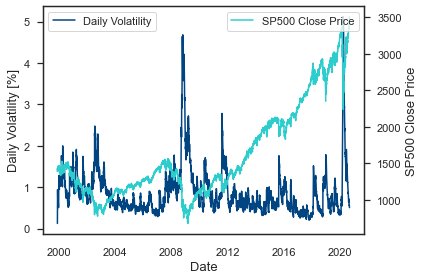

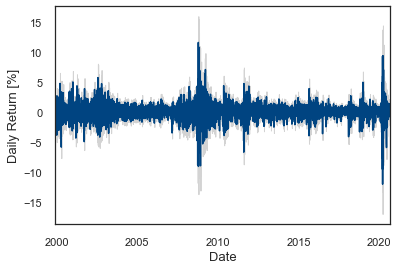

In [9]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('Date')
ax1.set_ylabel('Daily Volatility [%]')
ax1.plot(sp500_yahoo['Daily Volatility'], label='Daily Volatility')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('SP500 Close Price')  # we already handled the x-label with ax1
ax2.plot(sp500_yahoo['Close'], color=bbva[1], label='SP500 Close Price')
ax2.legend(loc='upper right')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

ax = (sp500_yahoo['Daily Return']).plot(kind='line',color=bbva[0], legend=False);
ax.fill_between(sp500_yahoo.index, 
                sp500_yahoo['Daily Return'] + sp500_yahoo['Daily Volatility'], 
                sp500_yahoo['Daily Return'] - sp500_yahoo['Daily Volatility'],
                color='lightgrey');
ax.set_ylabel('Daily Return [%]');

In [10]:
# just for plotting
cusum_events = mlfin.filters.cusum_filter(sp500_yahoo['Adj Close'], 
                                          threshold=0.1) #threshold abs(change)

# interactive plot
warnings.filterwarnings("ignore")
#enable_plotly_in_cell()

@interact
def plot_sentiment_index(dependent=widgets.Select(
                            options=['Volume', 'Adj Close', 'Daily Return', 'Daily Volatility'],
                            value='Adj Close',
                            # rows=10,
                            description='View',
                            disabled=False
                        ),
                        dataframe=widgets.RadioButtons(
                            options=['Companies', 'Countries', 'Currencies'],
                            value='Companies',
                            #rows=10,
                            description='Indices',
                            disabled=False
                        ),
                         sentiment1=widgets.Dropdown(
                            options=['buzz_US500',
                               'sentiment_US500', 'optimism_US500', 'joy_US500', 'loveHate_US500',
                               'trust_US500', 'anger_US500', 'conflict_US500', 'fear_US500',
                               'gloom_US500', 'stress_US500', 'surprise_US500', 'timeUrgency_US500',
                               'uncertainty_US500', 'violence_US500', 'emotionVsFact_US500',
                               'marketRisk_US500', 'longShort_US500', 'longShortForecast_US500',
                               'priceDirection_US500', 'priceForecast_US500', 'volatility_US500',
                               'analystRating_US500', 'debtDefault_US500', 'dividends_US500',
                               'innovation_US500', 'earningsForecast_US500',
                               'fundamentalStrength_US500', 'laborDispute_US500', 'layoffs_US500',
                               'litigation_US500', 'managementChange_US500', 'managementTrust_US500',
                               'mergers_US500', 'cyberCrime_US500'],
                            value='sentiment_US500',
                            #rows=10,
                            description='Comp. Val.',
                            disabled=False
                        ),
                         sentiment2=widgets.Dropdown(
                            options=['stockIndexBuzz_USA',
                               'bondBuzz_USA', 'ratesBuzz_USA', 'stockIndexSentiment_USA',
                               'stockIndexOptimism_USA', 'stockIndexTrust_USA', 'stockIndexFear_USA',
                               'stockIndexStress_USA', 'stockIndexSurprise_USA',
                               'stockIndexUncertainty_USA', 'stockIndexMarketRisk_USA',
                               'stockIndexPriceDirection_USA', 'stockIndexPriceForecast_USA',
                               'stockIndexVolatility_USA', 'bondSentiment_USA', 'bondOptimism_USA',
                               'bondTrust_USA', 'bondFear_USA', 'bondStress_USA', 'bondSurprise_USA',
                               'bondUncertainty_USA', 'bondDefault_USA', 'bondPriceDirection_USA',
                               'bondPriceForecast_USA', 'bondVolatility_USA', 'centralBank_USA',
                               'debtDefault_USA', 'interestRates_USA', 'interestRatesForecast_USA',
                               'monetaryPolicyLooseVsTight_USA', 'process_audit_load_USA'],
                            value='stockIndexSentiment_USA',
                            #rows=10,
                            description='Count. Val.',
                            disabled=False
                        ),
                         sentiment3=widgets.Dropdown(
                            options=['buzz_USD',
                               'sentiment_USD', 'optimism_USD', 'joy_USD', 'loveHate_USD', 'trust_USD',
                               'anger_USD', 'conflict_USD', 'fear_USD', 'gloom_USD', 'stress_USD',
                               'violence_USD', 'surprise_USD', 'timeUrgency_USD', 'uncertainty_USD',
                               'emotionVsFact_USD', 'marketRisk_USD', 'longShort_USD',
                               'longShortForecast_USD', 'priceDirection_USD', 'priceForecast_USD',
                               'volatility_USD', 'carryTrade_USD', 'currencyPegInstability_USD',
                               'priceMomentum_USD'],
                            value='sentiment_USD',
                            #rows=10,
                            description='Curr. Val.',
                            disabled=False,
                            layout={'positioning': 'right'}
                        )):
    
    if dataframe == 'Companies':
        sentiment = sentiment1
        df = companies
    elif dataframe == 'Countries':
        sentiment = sentiment2
        df = countries
    elif dataframe == 'Currencies':
        sentiment = sentiment3
        df = currencies
    
    figura = make_subplots(specs=[[{"secondary_y": True}]])

    figura.add_trace(go.Scatter(y=sp500_yahoo[dependent],
                                x=sp500_yahoo.index,
                                mode='lines',
                                name='SP500 '+ dependent),
                     secondary_y=True,)
    figura.add_trace(
        go.Scatter(y=df[sentiment],
                   x=df.index,
                   mode='lines',
                   name=sentiment + ' Index',
                   visible='legendonly'),
                   secondary_y=False,)
    figura.add_trace(
        go.Scatter(y=df[sentiment].ewm(span=365).mean(),
                   x=df.index,
                   mode='lines',
                   name='EWMA 1y ' + sentiment[:5] + '. Index'),
                   secondary_y=False,)
    figura.add_trace(
        go.Scatter(y=df[sentiment].ewm(span=180).mean(),
                   x=df.index,
                   mode='lines',
                   name='EWMA 6m ' + sentiment[:5] + '. Index'),
                   secondary_y=False,)
    figura.add_trace(
        go.Scatter(y=df[sentiment].ewm(span=90).mean(),
                   x=df.index,
                   mode='lines',
                   name='EWMA 3m ' + sentiment[:5] + '. Index'),
                   secondary_y=False,)
    figura.add_trace(
        go.Scatter(y=df[sentiment].ewm(span=30).mean(),
                   x=df.index,
                   mode='lines',
                   name='EWMA 1m ' + sentiment[:5] + '. Index',
                   visible='legendonly'),
                   secondary_y=False,)
    figura.add_trace(go.Scatter(y=sp500_yahoo['Adj Close'][cusum_events],
                                x=cusum_events,
                                mode='markers',
                                name='SP500 Index CUSUM Events'),
                     secondary_y=True,)
    figura.add_trace(
        go.Scatter(y=[0],
                   x=['2001-09-11'],
                   mode='markers',
                   name='Sept 11 Attacks',
                   marker=dict(size=15),
                   marker_symbol=17),
                   secondary_y=False,)
    figura.add_trace(
        go.Scatter(y=[0],
                   x=['2008-09-15'],
                   mode='markers',
                   name='Lehman Brothers Collapse',
                   marker=dict(size=15),
                   marker_symbol=17),
                   secondary_y=False,)
    figura.add_trace(
        go.Scatter(y=[0],
                   x=['2016-06-23'],
                   mode='markers',
                   name='Brexit Vote',
                   marker=dict(size=15),
                   marker_symbol=17),
                   secondary_y=False,)
    figura.add_trace(
        go.Scatter(y=[0],
                   x=['2020-01-20'],
                   mode='markers',
                   name='1st COVID-19 Case USA',
                   marker=dict(size=15),
                   marker_symbol=17),
                   secondary_y=False,)


    figura.update_layout(
        title_text='SP500 Index vs Sentiment Indices | Indicator: {}'.format(sentiment),
        colorway = bbva)

    figura.update_xaxes(rangeslider_visible=True)
    figura.update_yaxes(title_text="<b>Sentiment Index</b>", secondary_y=False)
    figura.update_yaxes(title_text="<b>Price</b>", secondary_y=True)

    figura.update_xaxes(
        rangeslider_visible=True,
        rangeselector=dict(
            dict(font = dict(color = "black")),
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(count=2, label="2y", step="year", stepmode="backward"),
                dict(count=3, label="3y", step="year", stepmode="backward"),
                dict(count=5, label="5y", step="year", stepmode="backward"),
                dict(step="all"),
            ])
        )
    )

    figura.update_layout(template='plotly_white', hovermode='x')
    iplot(figura)

interactive(children=(Select(description='View', index=1, options=('Volume', 'Adj Close', 'Daily Return', 'Dai…

## 2. Data preparation

In [11]:
sp500_yahoo = sp500_yahoo[original_columns]

In [12]:
companies.drop(['id_refinitiv_US500', 'asset_code_id_US500', 'data_type_US500', 
                'date_audit_laod_US500', 'process_audit_load_US500', 'system_version_US500'], 
               inplace=True, axis=1)
companies.drop_duplicates(inplace=True)
currencies.drop(['id_refinitiv_USD', 'asset_code_id_USD', 'data_type_USD', 
                 'date_audit_laod_USD', 'process_audit_load_USD', 'system_version_USD'], 
               inplace=True, axis=1)
currencies.drop_duplicates(inplace=True)
countries.drop(['id_refinitiv_USA', 'asset_code_id_USA', 'data_type_USA', 
                'date_audit_laod_USA', 'process_audit_load_USA', 'system_version_USA'], 
               inplace=True, axis=1)
countries.drop_duplicates(inplace=True)
sentiments = companies.merge(currencies.merge(countries, 
                                              left_index=True, right_index=True), left_index=True, right_index=True)
sentiments.head()

buzz_US500  sentiment_US500  optimism_US500  joy_US500  \
Date                                                                 
2000-01-01     33223.8         0.023402        0.016494   0.023959   
2000-01-02     36635.9         0.008134        0.014508   0.015217   
2000-01-03     57064.8         0.017612        0.014641   0.016096   
2000-01-04     79355.1         0.000825        0.006994   0.015147   
2000-01-05     91858.2        -0.013466        0.001110   0.014114   

            loveHate_US500  trust_US500  anger_US500  conflict_US500  \
Date                                                                   
2000-01-01        0.009060     0.001211     0.011212        0.011513   
2000-01-02        0.010864     0.000583     0.010099        0.015354   
2000-01-03        0.008429     0.000771     0.010471        0.014816   
2000-01-04        0.009514     0.001709     0.010907        0.012847   
2000-01-05        0.008225     0.000631     0.010941        0.011757   

            fear_US500  gloom_US500  ...  bondUncertainty_USA  \
Date                                 ...                        
2000-01-01    0.006727     0.027932  ...             0.006748   
2000-01-02    0.007206     0.027487  ...             0.023474   
2000-01-03    0.006983     0.032209  ...             0.009392   
2000-01-04    0.007145     0.032575  ...             0.006594   
2000-01-05    0.007327     0.031995  ...             0.007030   

            bondDefault_USA  bondPriceDirection_USA  bondPriceForecast_USA  \
Date                                                                         
2000-01-01              NaN               -0.053981               0.026991   
2000-01-02              NaN               -0.014085                    NaN   
2000-01-03         0.000648               -0.089708              -0.010687   
2000-01-04         0.004396               -0.023380              -0.001998   
2000-01-05         0.003409                0.008308              -0.001278   

            bondVolatility_USA  centralBank_USA  debtDefault_USA  \
Date                                                               
2000-01-01            0.014845         0.677966         0.220339   
2000-01-02            0.028169         0.840909         0.102273   
2000-01-03            0.069564         0.779070         0.085271   
2000-01-04            0.078094         0.702671         0.118467   
2000-01-05            0.060716         0.735938         0.115625   

            interestRates_USA  interestRatesForecast_USA  \
Date                                                       
2000-01-01           0.016949                        NaN   
2000-01-02           0.005682                   0.011364   
2000-01-03           0.042636                   0.011628   
2000-01-04           0.118467                   0.015099   
2000-01-05           0.095312                   0.010156   

            monetaryPolicyLooseVsTight_USA  
Date                                        
2000-01-01                             NaN  
2000-01-02                        0.005682  
2000-01-03                       -0.011628  
2000-01-04                       -0.004646  
2000-01-05                       -0.007813  

[5 rows x 90 columns]

In [13]:
# Calculamos una media ponderada para los lunes añadiendo la información de los fines de semana
mondays_weekends = []
for dt in daterange(start_date, end_date):
    if dt.isoweekday() in [1, 6, 7]:
        mondays_weekends.append(dt.strftime('%Y-%m-%d'))

senti_mon = sentiments.reindex(pd.DatetimeIndex(mondays_weekends))

In [14]:
# El primer día era sábado (servirá para colocar los pesos)
senti_mon.index[0]

Timestamp('1999-12-04 00:00:00')

In [15]:
# Continuación:
for col in senti_mon.columns:
    senti_mon[col] = \
        senti_mon[col].rolling(3).apply(lambda x: np.average(x, weights=[0.12, 0.22, 0.66])) 
        # damos mayor peso a los lunes (mon 2/3, sun 2/9, sat 1/9)
        
# Sustituimos sobre los índices de sentiments correspondientes a senti_mon
sentiments[sentiments.index.isin(mondays_weekends)] = senti_mon

del senti_mon

# Eliminamos fines de semana
sentiments = sentiments[sentiments.index.isin(weekdays)]
sentiments.head()

buzz_US500  sentiment_US500  optimism_US500  joy_US500  \
Date                                                                 
2000-01-03   49709.522         0.016222        0.014834   0.016846   
2000-01-04   79355.100         0.000825        0.006994   0.015147   
2000-01-05   91858.200        -0.013466        0.001110   0.014114   
2000-01-06  105962.800        -0.003497        0.005271   0.015430   
2000-01-07  122253.000        -0.007431        0.004474   0.015607   

            loveHate_US500  trust_US500  anger_US500  conflict_US500  \
Date                                                                   
2000-01-03        0.009040     0.000782     0.010478        0.014538   
2000-01-04        0.009514     0.001709     0.010907        0.012847   
2000-01-05        0.008225     0.000631     0.010941        0.011757   
2000-01-06        0.007866     0.001687     0.011820        0.012259   
2000-01-07        0.008642     0.001127     0.010294        0.010519   

            fear_US500  gloom_US500  ...  bondUncertainty_USA  \
Date                                 ...                        
2000-01-03    0.007001     0.030657  ...             0.012173   
2000-01-04    0.007145     0.032575  ...             0.006594   
2000-01-05    0.007327     0.031995  ...             0.007030   
2000-01-06    0.006304     0.028685  ...             0.010203   
2000-01-07    0.007210     0.032101  ...             0.015878   

            bondDefault_USA  bondPriceDirection_USA  bondPriceForecast_USA  \
Date                                                                         
2000-01-03              NaN               -0.068784                    NaN   
2000-01-04         0.004396               -0.023380              -0.001998   
2000-01-05         0.003409                0.008308              -0.001278   
2000-01-06         0.003601                0.062421               0.003601   
2000-01-07         0.001732                0.016455               0.002598   

            bondVolatility_USA  centralBank_USA  debtDefault_USA  \
Date                                                               
2000-01-03            0.053891         0.780542         0.105220   
2000-01-04            0.078094         0.702671         0.118467   
2000-01-05            0.060716         0.735938         0.115625   
2000-01-06            0.063502         0.694239         0.134417   
2000-01-07            0.059469         0.765446         0.094966   

            interestRates_USA  interestRatesForecast_USA  \
Date                                                       
2000-01-03           0.031424                        NaN   
2000-01-04           0.118467                   0.015099   
2000-01-05           0.095312                   0.010156   
2000-01-06           0.050222                   0.020679   
2000-01-07           0.068650                   0.019451   

            monetaryPolicyLooseVsTight_USA  
Date                                        
2000-01-03                             NaN  
2000-01-04                       -0.004646  
2000-01-05                       -0.007813  
2000-01-06                        0.000000  
2000-01-07                        0.000000  

[5 rows x 90 columns]

### Selecting train and test periods

In [16]:
# Dividimos en train y test

train_start = '2001-08-31'
train_end = '2016-08-31'
test_start = '2016-09-01'
test_end = '2020-08-31'

sentiments_test = sentiments[test_start:test_end]
sentiments_train = sentiments[train_start:train_end]
sp500_test = sp500_yahoo[test_start:test_end]
sp500_train = sp500_yahoo[train_start:train_end]

In [17]:
print(len(sp500_train)/len(sp500_yahoo[train_start:]))
print(len(sp500_test)/len(sp500_yahoo[train_start:]))

0.7895904781117612
0.21040952188823886


### Missing values

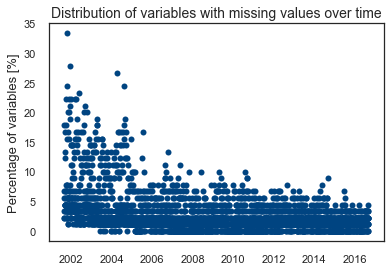

In [18]:
plt.plot(sentiments_train.isnull().sum(axis=1).index, 
         list((sentiments_train.isnull().sum(axis=1)/len(sentiments_train.columns))*100), 'o');
plt.title('Distribution of variables with missing values over time');
plt.ylabel('Percentage of variables [%]');
# el eje y representa el porcentaje de variables con valores faltantes
# en cada uno de los días del año (no son porcentajes de valores faltantes, para eso, ver apartado de Data Loading)

In [19]:
# Dropping cols with a missing rate larger than 20%
missing_rate = (sentiments_train.isnull().sum() / len(sentiments_train))*100
drop_cols = [col for col in missing_rate.index if missing_rate[col] >= 20]
print(drop_cols)
sentiments_train.drop(drop_cols, axis=1, inplace=True)
sentiments_test.drop(drop_cols, axis=1, inplace=True)

['carryTrade_USD', 'currencyPegInstability_USD']


In [20]:
# Imputing missing values for variables with a missing rate under 20%
# Hacemos forward fill al tratarse de noticias

sentiments_train.fillna(method='ffill', inplace=True) 
sentiments_test.fillna(method='ffill', inplace=True) 

In [21]:
#msno.matrix(sp500_yahoo[['Close']])

# Interpolamos en los días en los que hay nas (tanto porque son festivos y los mercados están cerrados, 
# como por falta real de valores)
print('Rate of missing values: {}'
      .format(round(
          len(sp500_yahoo[train_start:][sp500_yahoo[train_start:].Close.isnull()])/len(sp500_yahoo[train_start:]), 3)))
sp500_train.interpolate(method='spline', order=3, limit_direction='forward', 
                        axis=0, inplace=True) 
sp500_test.interpolate(method='spline', order=3, limit_direction='forward', 
                        axis=0, inplace=True) 

Rate of missing values: 0.036


### Transformations

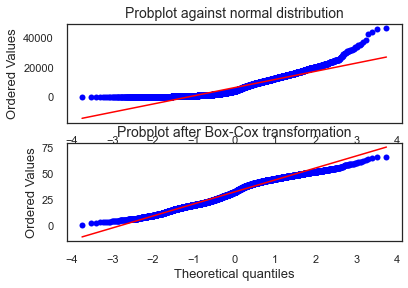

Lambda:  0.2749559707497384


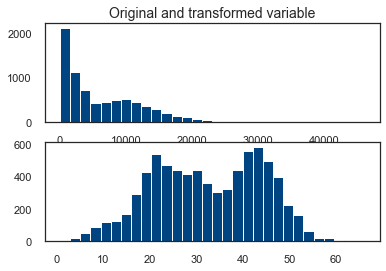

In [22]:
# Aplicamos yeo johnson para igualar dispersión en las variables

#ejemplo
fig = plt.figure()
ax1 = fig.add_subplot(211)
x = currencies.buzz_USD
prob = stats.probplot(x, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')

ax2 = fig.add_subplot(212)
xt, l = stats.yeojohnson(x)
prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation')
plt.show()
print('Lambda: ', l)

fig, ax = plt.subplots(2,1)
ax[0].hist(x, bins=30);
ax[1].hist(xt, bins=30);
ax[0].set_title('Original and transformed variable');

In [23]:
# We use the same lambdas for test dataset

def apply_transformation(data_train, data_test, transformation):
    
    data_train = data_train.dropna()
    data_test = data_test.dropna()
    
    index_train = data_train.index
    index_test = data_test.index
    
    if transformation == 'dispersion':
        for col in data_train.columns:
            data_train[col], fitted_lambda = stats.yeojohnson(data_train[col])
            data_test[col] = stats.yeojohnson(data_test[col], fitted_lambda)
            
    elif transformation == 'scale':
        scaler = StandardScaler().fit(data_train)
        std_train = scaler.transform(data_train)
        std_test = scaler.transform(data_test)
        data_train = pd.DataFrame(std_train, columns=data_train.columns)
        data_test = pd.DataFrame(std_test, columns=data_test.columns)
        data_train['Date'] = index_train
        data_test['Date'] = index_test
        data_train.set_index('Date', inplace=True)
        data_test.set_index('Date', inplace=True)
        
    elif transformation == 'dispersion_and_scale':
        for col in data_train.columns:
            data_train[col], fitted_lambda = stats.yeojohnson(data_train[col])
            data_test[col] = stats.yeojohnson(data_test[col], fitted_lambda)
        scaler = StandardScaler().fit(data_train)
        std_train = scaler.transform(data_train)
        std_test = scaler.transform(data_test)
        data_train = pd.DataFrame(std_train, columns=data_train.columns)
        data_test = pd.DataFrame(std_test, columns=data_test.columns)
        data_train['Date'] = index_train
        data_test['Date'] = index_test
        data_train.set_index('Date', inplace=True)
        data_test.set_index('Date', inplace=True)
    
    return data_train, data_test

In [24]:
sentiments_train.sentiment_US500.ewm(30).mean().corr(sp500_train['Close'].shift(22), method='pearson')

0.8480480700112257

In [25]:
# Now we apply standardization para igualar escalas. De esta forma las distribuciones son más comparables
sentiments_train, sentiments_test = apply_transformation(sentiments_train, sentiments_test, 'dispersion_and_scale')

display(sentiments_train.describe())

buzz_US500  sentiment_US500  optimism_US500     joy_US500  \
count  3.910000e+03     3.910000e+03    3.910000e+03  3.910000e+03   
mean   6.803878e-16    -4.974424e-16   -5.251554e-17 -1.275252e-15   
std    1.000128e+00     1.000128e+00    1.000128e+00  1.000128e+00   
min   -3.064271e+00    -3.836744e+00   -4.284522e+00 -3.013036e+00   
25%   -8.493998e-01    -6.976976e-01   -6.582821e-01 -7.451503e-01   
50%    3.815230e-02    -7.880494e-02   -1.911985e-02 -7.581875e-02   
75%    7.401832e-01     7.451540e-01    6.455215e-01  7.962038e-01   
max    2.942192e+00     3.112603e+00    3.886110e+00  3.362441e+00   

       loveHate_US500   trust_US500   anger_US500  conflict_US500  \
count    3.910000e+03  3.910000e+03  3.910000e+03    3.910000e+03   
mean     2.198156e-16 -4.195280e-17  1.171271e-15    9.881269e-18   
std      1.000128e+00  1.000128e+00  1.000128e+00    1.000128e+00   
min     -4.381088e+00 -6.928434e+00 -2.586858e+00   -4.609965e+00   
25%     -6.698294e-01 -6.259648e-01 -7.581757e-01   -6.460022e-01   
50%      2.395684e-03 -3.272897e-02 -8.365807e-02    1.615158e-02   
75%      6.810202e-01  5.983299e-01  8.139464e-01    6.483610e-01   
max      4.069919e+00  5.643069e+00  2.700716e+00    4.335172e+00   

         fear_US500   gloom_US500  ...  bondUncertainty_USA  bondDefault_USA  \
count  3.910000e+03  3.910000e+03  ...         3.910000e+03     3.910000e+03   
mean   1.374348e-15  6.720399e-16  ...        -3.112884e-16     4.515002e-16   
std    1.000128e+00  1.000128e+00  ...         1.000128e+00     1.000128e+00   
min   -3.552208e+00 -2.670639e+00  ...        -3.163638e+00    -8.062726e+00   
25%   -6.559033e-01 -7.677362e-01  ...        -6.686969e-01    -6.951505e-01   
50%    1.833695e-02 -2.910251e-02  ...        -6.556898e-03    -4.066074e-02   
75%    6.645912e-01  7.996133e-01  ...         6.920137e-01     6.463170e-01   
max    3.704308e+00  3.576385e+00  ...         3.779286e+00     2.888767e+00   

       bondPriceDirection_USA  bondPriceForecast_USA  bondVolatility_USA  \
count            3.910000e+03           3.910000e+03        3.910000e+03   
mean            -2.040851e-19           1.891070e-17        6.554291e-16   
std              1.000128e+00           1.000128e+00        1.000128e+00   
min             -6.847632e+00          -6.703713e+00       -4.173702e+00   
25%             -4.799653e-01          -4.732337e-01       -7.013733e-01   
50%             -4.698007e-02          -5.073219e-02       -3.039403e-02   
75%              5.109784e-01           4.678733e-01        7.241609e-01   
max              4.780882e+00           5.367399e+00        2.825161e+00   

       centralBank_USA  debtDefault_USA  interestRates_USA  \
count     3.910000e+03     3.910000e+03       3.910000e+03   
mean     -1.608120e-16     1.097218e-15       2.304494e-16   
std       1.000128e+00     1.000128e+00       1.000128e+00   
min      -3.048743e+00    -2.270924e+00      -9.733690e+00   
25%      -6.927469e-01    -7.495620e-01      -5.990254e-01   
50%       4.215866e-03     4.375376e-03      -1.634409e-01   
75%       6.946301e-01     7.372704e-01       4.860234e-01   
max       2.955895e+00     3.014466e+00       2.787403e+00   

       interestRatesForecast_USA  monetaryPolicyLooseVsTight_USA  
count               3.910000e+03                    3.910000e+03  
mean                5.224579e-18                   -3.448790e-16  
std                 1.000128e+00                    1.000128e+00  
min                -1.687397e+01                   -9.594321e+00  
25%                -4.879330e-01                   -6.143743e-01  
50%                -2.458350e-01                   -2.346027e-01  
75%                 2.338346e-01                    6.134070e-01  
max                 5.097762e+00                    2.267225e+00  

[8 rows x 88 columns]

In [26]:
sentiments_train.sentiment_US500.ewm(30).mean().corr(sp500_train['Close'].shift(22), method='pearson')

0.8423010596116391

### Smoothing

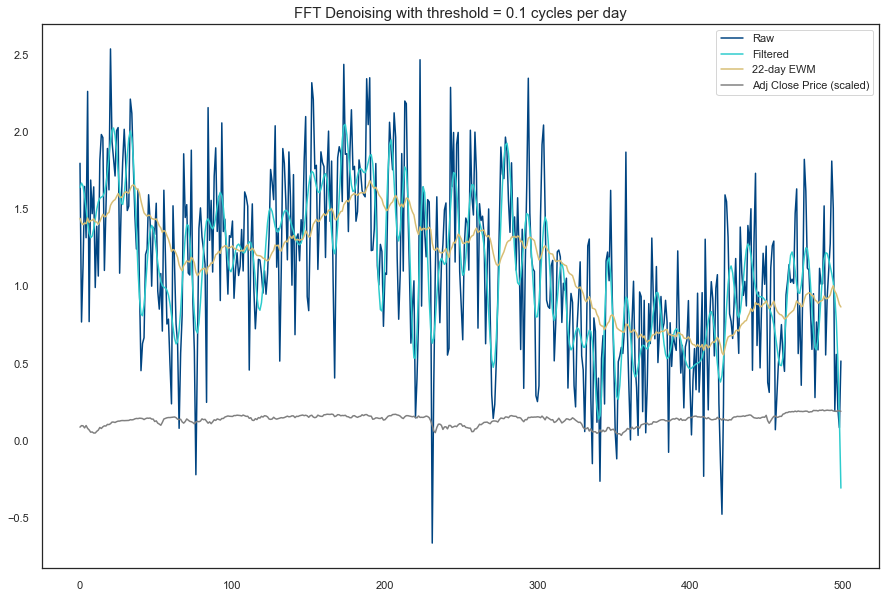

In [27]:
def filter_signal(signal, threshold=1e8):
    fourier = np.fft.rfft(signal)
    frequencies = np.fft.rfftfreq(signal.size, d=1.)
    fourier[frequencies > threshold] = 0
    return np.fft.irfft(fourier)

span = 500
signal = np.array(sentiments_train.sentiment_US500[1:])
threshold = 0.1
filtered = filter_signal(signal, threshold=threshold)
plt.figure(figsize=(15, 10))
plt.plot(signal[-span:], label='Raw')
#plt.plot(signal[-100:], 'bo', label='Raw')
plt.plot(filtered[-span:], label='Filtered')
plt.plot(np.array(pd.Series(signal).ewm(22).mean())[-span:], label='22-day EWM')
plt.plot(np.array(sp500_train['Adj Close'][-span:]/max(sp500_train['Adj Close'][-span:])) - 0.8,
         label='Adj Close Price (scaled)', color='gray')
#plt.plot(filtered[-500:], 'ro', label='Filtered')
plt.legend()
plt.title("FFT Denoising with threshold = {} cycles per day".format(threshold), size=15)
plt.show()

In [28]:
# Function for selecting smoothing technique
def select_smoothing(data, technique, span0=22):
    if technique == 'fft':
        filtered = list(filter_signal(data, threshold=threshold))
        filtered.append(0)
    elif technique == 'ewm':
        filtered = data.ewm(span=span0).mean()
    return filtered

for col in sentiments_train.columns:
    sentiments_train[col] = select_smoothing(sentiments_train[col], 'ewm')
    sentiments_test[col] = select_smoothing(sentiments_test[col], 'ewm')

### Feature engineering

#### PCA

[0.415733   0.14789792 0.06647239]


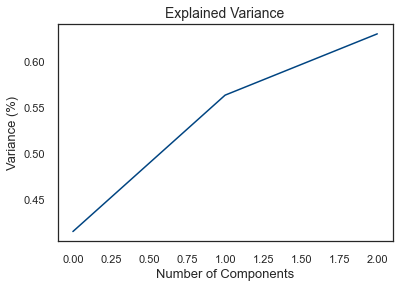

[0.38160817 0.12545345 0.09700314]


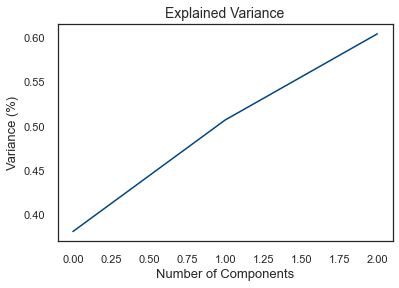

In [30]:
def apply_pca(data, scale=False):
    # Separating out the features
    # already separated
    data = data.dropna()
    x = data
    
    # Standardizing the features
    if scale is True:
        x = StandardScaler().fit_transform(x) #already transformed
    pca = PCA(n_components=3)
    x_pca = pca.fit_transform(x)
    pDf = pd.DataFrame(data = x_pca, 
                       columns = ['pc1', 'pc2', 'pc3'])

    data.reset_index(inplace=True)
    data['pc1'] = pDf.pc1
    data['pc2'] = pDf.pc2
    data['pc3'] = pDf.pc3
    data.set_index('Date', inplace=True)

    print(pca.explained_variance_ratio_)
    
    plt.figure()
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Variance (%)') 
    plt.title('Explained Variance')
    plt.show()

    return data

sentiments_train = apply_pca(sentiments_train, scale=False)
sentiments_test = apply_pca(sentiments_test, scale=False)

#### Technical indicators

[TA Library Documentation](https://technical-analysis-library-in-python.readthedocs.io/en/latest/ta.html)

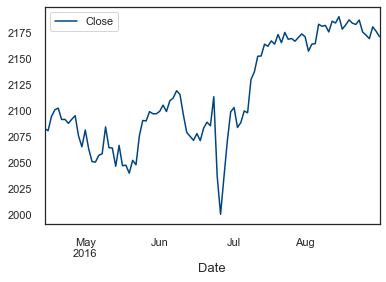

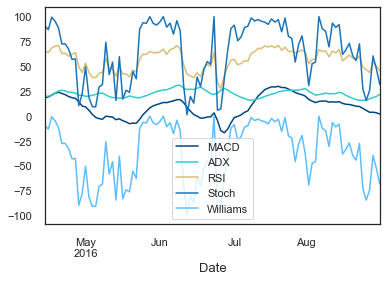

In [31]:
def add_technical_indicators(data):
    # data cannot contain nans before fft
    data.dropna(inplace=True)
    #d = 10 # horizonte de predicción (aquí hacia atrás)
    #fft_close = filter_signal(data['Adj Close'])
    #data['FFT Discrete Close'] = [np.sign(fft_close[i] - fft_close[i - d])
    #                              if (i - d > 0) and (i < len(fft_close)) else np.nan
    #                              for i in range(0, len(fft_close) + 1)]
    #
    data['ROC'] = ROCIndicator(data['Adj Close'], 10).roc()
    data['RSI'] = RSIIndicator(data['Adj Close'], 10).rsi()
    data['Stoch'] = StochasticOscillator(high=data['High'], 
                                         low=data['Low'], 
                                         close=data['Close'], 
                                         n=10).stoch()
    data['Williams'] = WilliamsRIndicator(high=data['High'], 
                                          low=data['Low'], 
                                          close=data['Close'],  
                                          lbp=10).wr()
    data['MACD'] = MACD(data['Close'], 
                        n_slow = 22, 
                        n_fast = 8, 
                        n_sign = 5).macd()
    data['ADX'] = ADXIndicator(high=data['High'], 
                               low=data['Low'], 
                               close=data['Close'], n=10).adx()
    
    data['Close/Open'] = [1 if data.Close[x] > data.Open[x] else 0
                          for x in range(0, len(data))]
    
    data['Daily Return'] = data['Adj Close'].pct_change(periods=1)*100
    data['Daily Volatility'] = data['Daily Return'].ewm(span=22).std() # exponential moving std
    
    ### only compute this cross if it won't later be the primary model!!
    fast_window = 20
    slow_window = 60
    col = 'Adj Close'
    data['Fast EWMA {}'.format(col)] = data[col] # already averaged
    data['Slow EWMA {}'.format(col)] = data[col].ewm(slow_window).mean()

    # Compute sides
    data['sp_cross_{}'.format(col)] = np.nan

    long_signals = data['Fast EWMA {}'.format(col)] >= data['Slow EWMA {}'.format(col)]
    short_signals = data['Fast EWMA {}'.format(col)] < data['Slow EWMA {}'.format(col)]
    data.loc[long_signals, 'sp_cross_{}'.format(col)]  = 1
    data.loc[short_signals, 'sp_cross_{}'.format(col)]  = -1

    # Lagging our trading signals by one day
    #data[['Fast EWMA', 'Slow EWMA']] = data[['Fast EWMA', 'Slow EWMA']].shift(1)

    data.drop(['Fast EWMA {}'.format(col), 'Slow EWMA {}'.format(col)], axis=1, inplace=True)

    return data

sp500_train = add_technical_indicators(sp500_train)
sp500_test = add_technical_indicators(sp500_test)

sp500_train.Close[-100:].plot(legend=True);
plt.figure()
sp500_train.MACD[-100:].plot(legend=True);
sp500_train.ADX[-100:].plot(legend=True);
sp500_train.RSI[-100:].plot(legend=True);
sp500_train.Stoch[-100:].plot(legend=True);
sp500_train.Williams[-100:].plot(legend=True);

In [32]:
# dropping high, low, open and close variables
#sp500_train.drop(['High', 'Low', 'Open', 'Close'], axis=1, inplace=True)
#sp500_test.drop(['High', 'Low', 'Open', 'Close'], axis=1, inplace=True)
sp500_train.drop(['Close'], axis=1, inplace=True)
sp500_test.drop(['Close'], axis=1, inplace=True)

### Labeling target variable

In [33]:
# antes de continuar, juntamos los dfs de sentimiento y del sp500
sp500_train = sp500_train.shift(1) # avanzamos solamente los datos de precio porque las noticias del día han de utilizarse
# para predecir el precio al día siguiente
sp500_test = sp500_test.shift(1)

In [55]:
X_train = pd.concat([sp500_train, sentiments_train], axis=1)
X_test = pd.concat([sp500_test, sentiments_test], axis=1)
X_train.dropna(inplace=True) # hay nas al comienzo, para las variables de indicadores técnicos
X_test.dropna(inplace=True)

# las variables y_train e y_test serán las que creemos a continuación

In [35]:
# overriding function get_bins
# we want this to return the sign of the return when the vertical barrier is touched first
# instead of what it's currently implemented (0 if vertical barrier is touched first)
def get_bins(triple_barrier_events, close):
    """
    Advances in Financial Machine Learning, Snippet 3.7, page 51.

    Labeling for Side & Size with Meta Labels

    Compute event's outcome (including side information, if provided).
    events is a DataFrame where:

    Now the possible values for labels in out['bin'] are {0,1}, whether to take the bet or pass,
    a purely binary prediction. The previous feasible values were {−1,0,1}.
    The ML algorithm will be trained to decide if it's 1, and we can use the probability of this secondary prediction
    to derive the size of the bet, where the side (sign) of the position has been set by the primary model.

    :param triple_barrier_events: (pd.DataFrame)
                -events.index is event's starttime
                -events['t1'] is event's endtime
                -events['trgt'] is event's target
                -events['side'] (optional) implies the algo's position side
                Case 1: ('side' not in events): bin in (-1,1) <-label by price action
                Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    :param close: (pd.Series) Close prices
    :return: (pd.DataFrame) Meta-labeled events
    """

    # 1) Align prices with their respective events
    events_ = triple_barrier_events.dropna(subset=['t1'])
    all_dates = events_.index.union(other=events_['t1'].array).drop_duplicates()
    prices = close.reindex(all_dates, method='bfill')

    # 2) Create out DataFrame
    out_df = pd.DataFrame(index=events_.index)
    # Need to take the log returns, else your results will be skewed for short positions
    #out_df['ret'] = np.log(prices.loc[events_['t1'].array].array) - np.log(prices.loc[events_.index])
    out_df['ret'] = prices.loc[events_['t1'].values].values / prices.loc[events_.index] - 1
    out_df['trgt'] = events_['trgt']

    # Meta labeling: Events that were correct will have pos returns
    if 'side' in events_:
        out_df['ret'] = out_df['ret'] * events_['side']  # meta-labeling

    # Added code: label 0 when vertical barrier reached
    #-------------------we change this step, as we want the outcome to be the sign of the return
    #out_df = barrier_touched(out_df, triple_barrier_events) 
    out_df['bin'] = np.sign(out_df['ret'])

    # Meta labeling: label incorrect events with a 0
    if 'side' in events_:
        out_df.loc[out_df['ret'] <= 0, 'bin'] = 0

    # Transform the log returns back to normal returns.
    #out_df['ret'] = np.exp(out_df['ret']) - 1

    # Add the side to the output. This is useful for when a meta label model must be fit
    tb_cols = triple_barrier_events.columns
    if 'side' in tb_cols:
        out_df['side'] = triple_barrier_events['side']

    return out_df


In [36]:
def apply_trading_labeling(data, 
                           compute_side=False, 
                           horizon=14,
                           pt_sl=[1, 2], # multipliers for daily vol (contribution to horizontal barriers)
                           min_ret=0.005,
                           primary_model=False):
    """
    Applies selected trading strategy with the given parameters. Labeling uses Triple Barrier Method.

    Parameters
    __________
    dataframe: pandas dataframe 
        Data to use.
    compute_side: boolean
        Whether to use a primary model that tells the side (buy or sell).
        When True, a trend-following strategy will be applied as primary model.
        Default is False.
    horizon: int
        Prediction horizon in natural days.
    pt_sl: list
        Profit taking and stop loss multipliers to the volatility. Width of the TBM box.
    min_ret: float
        Minimum target return to run the search for triple barriers.
    primary_model: boolean
        Whether a primary model computed by the user has already decided the side.
    """

    ####--------------------- Primary models ------------------------####
    if compute_side is True:
        # compute exponentially moving averages
        fast_window = 20
        slow_window = 90 # optimize the span for fast and slow averages

        data['Fast EWMA'] = data['Adj Close'].ewm(fast_window).mean()
        data['Slow EWMA'] = data['Adj Close'].ewm(slow_window).mean()
    
        # Compute sides
        data['Side'] = np.nan

        long_signals = data['Fast EWMA'] >= data['Slow EWMA']
        short_signals = data['Fast EWMA'] < data['Slow EWMA']
        data.loc[long_signals, 'Side'] = 1
        data.loc[short_signals, 'Side'] = -1

        # Lagging our trading signals by one day
        data[['Fast EWMA', 'Slow EWMA']] = data[['Fast EWMA', 'Slow EWMA']].shift(1)

        data[['Fast EWMA', 'Slow EWMA']].plot();
    
    data.dropna(inplace=True)

    ####--------------------- CUSUM filters ------------------------####
    # Apply Symmetric CUSUM Filter and get timestamps for events
    cusum_events = mlfin.filters.cusum_filter(data['Adj Close'],
                                              threshold=data['Daily Volatility']/100)

    ####--------------------- Vertical barriers ------------------------####
    # Compute vertical barrier
    vertical_barriers = mlfin.labeling.add_vertical_barrier(t_events=cusum_events,
                                                            close=data['Adj Close'],
                                                            num_days=horizon) # this is the length of the tbm box
    
    ####--------------------- Triple barriers ------------------------####
    # Computing triple barriers
    if (compute_side is True) | (primary_model is True):
        triple_barrier_events = mlfin.labeling.get_events(close=data['Adj Close'],
                                                       t_events=cusum_events,
                                                       pt_sl=pt_sl, # profit taking and stop loss multiples
                                                       target=data['Daily Volatility']/100, # values in conjunction with pt_sl for width of barrier
                                                       min_ret=min_ret,
                                                       num_threads=3, # num of parallel tasks
                                                       vertical_barrier_times=vertical_barriers,
                                                       side_prediction=data.Side)
        ####--------------------- Meta-labels ------------------------####
        # now we compute the meta-labelling
        meta_labeled_events = get_bins(triple_barrier_events, data['Adj Close'])
    
    else:
        triple_barrier_events = mlfin.labeling.get_events(close=data['Adj Close'],
                                                       t_events=cusum_events,
                                                       pt_sl=pt_sl, # profit taking and stop loss multiples
                                                       target=data['Daily Volatility']/100, # values in conjunction with pt_sl for width of barrier
                                                       min_ret=min_ret,
                                                       num_threads=3, # num of parallel tasks
                                                       vertical_barrier_times=vertical_barriers,
                                                       side_prediction=None)

        ####--------------------- Side ------------------------####
        # now we compute the side 
        # function that does meta-labeling returns side if no side prediction comes first
        meta_labeled_events = get_bins(triple_barrier_events, data['Adj Close'])
        meta_labeled_events['side'] = meta_labeled_events['bin']
        meta_labeled_events['bin'] = 1

    return meta_labeled_events, triple_barrier_events


#### No primary model

In [56]:
# computing labels for side (+1, -1)
train_labels, tbm_train = apply_trading_labeling(X_train, 
                                     primary_model=False, 
                                     compute_side=False,
                                     horizon=14,
                                     pt_sl=[1, 2],
                                     min_ret=0.005)
test_labels, tbm_test = apply_trading_labeling(X_test, 
                                     primary_model=False, 
                                     compute_side=False,
                                     horizon=14,
                                     pt_sl=[1, 2],
                                     min_ret=0.005)

2020-10-13 02:18:12.073951 100.0% apply_pt_sl_on_t1 done after 0.1 minutes. Remaining 0.0 minutes..
2020-10-13 02:18:19.245756 100.0% apply_pt_sl_on_t1 done after 0.09 minutes. Remaining 0.0 minutes..


In [57]:
display(train_labels.head())
display(tbm_train.head())

ret      trgt  bin  side
2001-10-04  0.023455  0.017967    1   1.0
2001-10-11  0.003895  0.015892    1   1.0
2001-10-17 -0.018633  0.013810    1  -1.0
2001-10-18  0.021354  0.014603    1   1.0
2001-10-23 -0.027626  0.013648    1  -1.0

t1      trgt  pt  sl
2001-10-04 2001-10-12  0.017967   1   2
2001-10-11 2001-10-25  0.015892   1   2
2001-10-17 2001-10-18  0.013810   1   2
2001-10-18 2001-10-26  0.014603   1   2
2001-10-23 2001-10-31  0.013648   1   2

In [58]:
# plotting labels to see outcome
@interact
def plot_sentiment_index(data=widgets.RadioButtons(
                            options=['Train', 'Test'],
                            value='Test',
                            # rows=10,
                            description='Data',
                            disabled=False)):

    figura = make_subplots(specs=[[{"secondary_y": False}]])
    if data == 'Test':
        dataset = X_test.merge(test_labels,
                            left_index=True,
                            right_index=True,
                            how='left')
        figura.add_trace(go.Scatter(y=X_test['Adj Close'],
                                    x=X_test.index,
                                    mode='lines',
                                    name='SP500 Close Price'),
                         secondary_y=False,)
    else:
        dataset = X_train.merge(train_labels,
                            left_index=True,
                            right_index=True,
                            how='left')
        figura.add_trace(go.Scatter(y=X_train['Adj Close'],
                                    x=X_train.index,
                                    mode='lines',
                                    name='SP500 Close Price'),
                         secondary_y=False,)
    if ('Fast EWMA' in dataset.columns) and ('Slow EWMA' in dataset.columns):
        figura.add_trace(go.Scatter(y=dataset['Fast EWMA'],
                                    x=dataset.index,
                                    mode='lines',
                                    name='SP500 Fast EWMA'),
                         secondary_y=False,)
        figura.add_trace(go.Scatter(y=dataset['Slow EWMA'],
                                    x=dataset.index,
                                    mode='lines',
                                    name='SP500 Slow EWMA'),
                         secondary_y=False,)

    figura.add_trace(
        go.Scatter(y=dataset[(dataset.bin == 1) & (dataset.side == 1)]['Adj Close'],
                   x=dataset[(dataset.bin == 1) & (dataset.side == 1)].index,
                   mode='markers',
                   name='Buy',
                   marker=dict(size=8, color='#008000'),
                   marker_symbol=5),
                   secondary_y=False,)
    figura.add_trace(
        go.Scatter(y=dataset[(dataset.bin == 1) & (dataset.side == -1)]['Adj Close'],
                   x=dataset[(dataset.bin == 1) & (dataset.side == -1)].index,
                   mode='markers',
                   name='Sell',
                   marker=dict(size=8, color='#FF0000'),
                   marker_symbol=6),
                   secondary_y=False,)

    figura.update_layout(
        title_text='SP500 Index and labeled positions | {}'.format(data),
        colorway = bbva)

    figura.update_xaxes(rangeslider_visible=True)
    figura.update_yaxes(title_text="<b>Price</b>", secondary_y=False)

    figura.update_xaxes(
        rangeslider_visible=True,
        rangeselector=dict(
            dict(font = dict(color = "black")),
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(count=2, label="2y", step="year", stepmode="backward"),
                dict(count=3, label="3y", step="year", stepmode="backward"),
                dict(count=5, label="5y", step="year", stepmode="backward"),
                dict(step="all"),
            ])
        )
    )

    figura.update_layout(template='plotly_white', hovermode='x')
    iplot(figura)

interactive(children=(RadioButtons(description='Data', index=1, options=('Train', 'Test'), value='Test'), Outp…

In [59]:
# number of observations per label
train_labels['label'] = train_labels['bin'] * train_labels['side']
print(train_labels.groupby('label').count()[['ret']])

test_labels['label'] = test_labels['bin'] * test_labels['side']
print(test_labels.groupby('label').count()[['ret']])

       ret
label     
-1.0   668
 1.0   820
       ret
label     
-1.0    90
 1.0   168


In [60]:
# we add them as predictor variables
def add_crossing_ewmas(data, fast_window, slow_window):

    #fast_window = 20 # 1 working month
    #slow_window = 90 # 5 working months

    for col in ['sentiment_US500', 'stockIndexSentiment_USA']:

        data['Fast EWMA {}'.format(col)] = data[col] # already averaged
        data['Slow EWMA {}'.format(col)] = data[col].ewm(slow_window).mean()

        # Compute sides
        data['cross_{}'.format(col)] = np.nan

        long_signals = data['Fast EWMA {}'.format(col)] >= data['Slow EWMA {}'.format(col)]
        short_signals = data['Fast EWMA {}'.format(col)] < data['Slow EWMA {}'.format(col)]
        data.loc[long_signals, 'cross_{}'.format(col)]  = 1
        data.loc[short_signals, 'cross_{}'.format(col)]  = -1

        # Lagging our trading signals by one day
        #data[['Fast EWMA', 'Slow EWMA']] = data[['Fast EWMA', 'Slow EWMA']].shift(1)

        data.drop(['Fast EWMA {}'.format(col), 'Slow EWMA {}'.format(col)], axis=1, inplace=True)
    
    return data

X_train = add_crossing_ewmas(X_train, 10, 60)
X_test = add_crossing_ewmas(X_test, 10, 60)

In [61]:
# scaling price variables
X_train[sp500_train.columns], X_test[sp500_test.columns] = apply_transformation(X_train[sp500_train.columns],
                                                                                X_test[sp500_test.columns],
                                                                                'dispersion_and_scale')

In [62]:
# eliminamos label 0
train_labels = train_labels[train_labels.label != 0]
test_labels = test_labels[test_labels.label != 0]

# downsampling with events
X_train = X_train.reindex(train_labels.index)
X_test = X_test.reindex(test_labels.index)

X_train.head()

High       Low      Open  Volume  Adj Close       ROC  \
2001-10-04 -0.807969 -0.873574 -0.871239     0.0  -0.786130  1.808582   
2001-10-11 -0.782429 -0.827435 -0.848776     0.0  -0.751163  2.513995   
2001-10-17 -0.701903 -0.691118 -0.714693     0.0  -0.685855  1.378815   
2001-10-18 -0.680350 -0.732335 -0.685032     0.0  -0.766768 -0.016683   
2001-10-23 -0.746187 -0.755141 -0.780502     0.0  -0.715821  0.714642   

                 RSI     Stoch  Williams      MACD  ...  centralBank_USA  \
2001-10-04  0.422597  1.165098  1.293337 -1.006822  ...         0.537591   
2001-10-11  0.551618  1.128432  1.220651 -0.226302  ...        -0.129103   
2001-10-17  0.851356  1.035913  1.059161  0.705309  ...        -0.370464   
2001-10-18 -0.079297 -0.407315 -0.529535  0.534852  ...        -0.357195   
2001-10-23  0.351889  0.307352  0.146069  0.269745  ...        -0.604699   

            debtDefault_USA  interestRates_USA  interestRatesForecast_USA  \
2001-10-04        -0.174197          -0.519892                  -0.340690   
2001-10-11         0.380515          -0.996558                  -0.762076   
2001-10-17         0.629447          -0.831857                  -0.514771   
2001-10-18         0.643653          -0.797990                  -0.467564   
2001-10-23         0.790327          -0.724182                  -0.378894   

            monetaryPolicyLooseVsTight_USA       pc1       pc2       pc3  \
2001-10-04                        0.161353  6.837807 -0.156975 -0.360326   
2001-10-11                       -0.416752  6.610237 -0.600299 -0.468336   
2001-10-17                       -0.377919  6.451449 -0.751939 -0.411955   
2001-10-18                       -0.378449  6.507134 -0.523095 -0.472044   
2001-10-23                       -0.386394  6.193373 -0.884154 -0.287341   

            cross_sentiment_US500  cross_stockIndexSentiment_USA  
2001-10-04                    1.0                            1.0  
2001-10-11                    1.0                            1.0  
2001-10-17                    1.0                            1.0  
2001-10-18                    1.0                            1.0  
2001-10-23                    1.0                            1.0  

[5 rows x 108 columns]

In [63]:
X_train.to_csv('x_train_pt_sl.csv', index=False)
X_test.to_csv('x_test_pt_sl.csv', index=False)

## 3. Model

In [45]:
def apply_model(train_labels, test_labels, X_train_, X_test_, model, scoring, sfs=True):
    
    y_test = test_labels.label
    y_train = train_labels.label
    
    pos_ratio = round(train_labels[train_labels.label <= 0][['label']].count() / 
                      train_labels[train_labels.label > 0][['label']].count(), 1)[0]
    
    if sfs is True:
    # Sequential Forward Floating Selection
        sffs = SFS(RandomForestClassifier(n_jobs=-1, random_state=1, n_estimators=40, max_depth=2,
                                          class_weight='balanced_subsample'), 
                   k_features=(10, 30), 
                   forward=True, 
                   floating=True, 
                   scoring=scoring,
                   cv=5,
                   n_jobs=-1,
                   verbose=0)

        sffs = sffs.fit(X_train_, y_train)

        print('\nSequential Forward Floating Selection (k=30):')
        sffs_score = sffs.k_score_
        print('CV Score: %.2f' % sffs_score)

        fig1 = plot_sfs(sffs.get_metric_dict(), kind='std_dev')

        #plt.ylim([0.8, 1])
        plt.title('Sequential Forward Selection (w. StdDev)')
        #plt.grid()
        plt.show()

        selected_cols = []
        for i, col in enumerate(X_train_.columns):
            if i in sffs.k_feature_idx_:
                selected_cols.append(col)

        X_train_ = X_train_[selected_cols]
        X_test_ = X_test_[selected_cols]
    else:
        selected_cols = X_train_.columns
        
    # Fitting model:
    if model == 'RF':        
        parameters = {'n_estimators': [40, 60, 100, 150, 180],
                      'max_depth':[2, 3, 4, 5],
                      'min_samples_split': [4, 6],
                      'min_samples_leaf': [1, 2],
                      'ccp_alpha': [0, 0.01, 0.02]}
        
        clf = RandomForestClassifier(n_jobs=-1, oob_score=True, criterion='gini', 
                                     random_state=1, class_weight='balanced_subsample')
        
        gridcv = GridSearchCV(clf, parameters, cv=TimeSeriesSplit(max_train_size=None, n_splits=5), 
                              scoring=scoring, verbose=1, n_jobs=-1, refit=True)
    elif model == 'XGB':
        parameters = {'n_estimators': [40, 60, 100, 180],
                      'max_depth':[2, 3, 4, 5],
                      'eta': [0.0005, 0.005, 0.01],
                      'base_score': [0, 0.5, 1],
                      'early_stopping_rounds':[5, 10]}#,
                      #'scale_pos_weight': [0.5, 0.8, 1]}
        
        clf = XGBClassifier(objective='binary:logistic', predictor='gpu_predictor',
                            random_state=1, min_child_weight=2, scale_pos_weight=pos_ratio)
    
        # As this is a time-series problem, we do not shuffle samples for Cross-Validation,
        # and test always with newer registers:
        gridcv = GridSearchCV(clf, parameters, cv=TimeSeriesSplit(max_train_size=None, n_splits=3), 
                              verbose=1, n_jobs=-1, refit=True, scoring=scoring)

    gridcv.fit(X_train_, y_train)

    # Results:
    best_estimator = gridcv.best_estimator_
    #cv_results, cv_results_index = gridcv.cv_results_, gridcv.best_index_

    print("Train best score %.2f" % gridcv.best_score_)
    print('Best parameters: {}'.format(gridcv.best_params_))

    predictions = best_estimator.predict(X_test_)
    accuracy = accuracy_score(y_test, predictions)*100
    print("Accuracy: %.2f%%" % accuracy)
    y_pred = gridcv.predict_proba(X_test_)[:,1]
    print("AUC: %.2f" % roc_auc_score(y_test, y_pred))
    if model == 'RF':
        print("OOB Score: %.2f" % best_estimator.oob_score_)
    print("Classification report:")
    print(classification_report(y_test, predictions))

    conf_mat = confusion_matrix(y_test, predictions)
    print("Confusion matrix:")
    print(conf_mat)
    
    with plt.style.context('seaborn-poster'):
        features = X_train_.columns
        importances = np.array([importance for importance in best_estimator.feature_importances_ if importance > 0])
        indices = np.argsort(importances)

        plt.title('Feature Importances')
        plt.barh(range(len(indices)), importances[indices], color='b', align='center')
        plt.yticks(range(len(indices)), [features[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()
    
    return best_estimator, selected_cols

In [106]:
# choosing variables
def choose_variables(X_train, X_test, var_type='technical'):
    sentiment_cols = [col for col in X_test.columns 
                      if col.endswith(('USA', 'US500', 'USD')) 
                      or col.startswith(('pc', 'cross'))]
    if var_type == 'technical':
        # solo indicadores técnicos
        X_train_ = X_train[[col for col in X_train.columns if col not in sentiment_cols]]
        X_test_ = X_test[[col for col in X_test.columns if col not in sentiment_cols]]
    elif var_type == 'sentiment':
        #solo indicadores de sentimiento
        X_train_ = X_train[sentiment_cols]
        X_test_ = X_test[sentiment_cols]
    elif var_type == 'all':
        X_train_ = X_train
        X_test_ = X_test
    #X_train_.drop('Volume', axis=1, inplace=True)
    #X_test_.drop('Volume', axis=1, inplace=True)
    return X_train_, X_test_

X_train_, X_test_ = choose_variables(X_train, X_test, 'all')

In [111]:
features2 = ['High', 'Low', 'Open', 'Adj Close', 'ROC', 'RSI', 'Stoch',
           'Williams', 'MACD', 'ADX', 'Close/Open', 'Daily Return',
           'Daily Volatility', 'sp_cross_Adj Close']
features4 = ['ROC',
 'ADX',
 'Daily Return',
 'fear_US500',
 'fundamentalStrength_US500',
 'optimism_USD',
 'surprise_USD',
 'timeUrgency_USD',
 'longShort_USD',
 'bondDefault_USA',
 'bondPriceForecast_USA',
 'interestRates_USA',
 'cross_stockIndexSentiment_USA']
features5 = ['fear_US500',
 'fundamentalStrength_US500',
 'optimism_USD',
 'surprise_USD',
 'longShort_USD',
 'priceForecast_USD',
 'stockIndexStress_USA',
 'bondUncertainty_USA',
 'bondPriceForecast_USA',
 'interestRates_USA',
 'cross_stockIndexSentiment_USA']
features6 = ['fear_US500',
 'fundamentalStrength_US500',
 'optimism_USD',
 'surprise_USD',
 'longShort_USD',
 'priceForecast_USD',
 'stockIndexStress_USA',
 'bondUncertainty_USA',
 'bondPriceForecast_USA',
 'interestRates_USA',
 'cross_stockIndexSentiment_USA',
 'High', 'Low', 'Open', 'Adj Close', 'ROC', 'RSI', 'Stoch',
 'Williams', 'MACD', 'ADX', 'Close/Open', 'Daily Return',
 'Daily Volatility', 'sp_cross_Adj Close']    
features7 = ['Stoch',
 'Williams',
 'MACD',
 'ADX',
 'Close/Open',
 'sp_cross_Adj Close',
 'longShortForecast_US500',
 'analystRating_US500',
 'dividends_US500',
 'stress_USD',
 'stockIndexPriceDirection_USA',
 'stockIndexPriceForecast_USA',
 'cross_stockIndexSentiment_USA'] # pt sl
features8 = ['longShortForecast_US500',
 'priceForecast_US500',
 'analystRating_US500',
 'trust_USD',
 'stress_USD',
 'surprise_USD',
 'timeUrgency_USD',
 'longShort_USD',
 'volatility_USD',
 'stockIndexPriceDirection_USA',
 'bondUncertainty_USA',
 'interestRates_USA',
 'cross_stockIndexSentiment_USA'] # pt sl
features9 = ['longShortForecast_US500',
 'priceForecast_US500',
 'analystRating_US500',
 'trust_USD',
 'stress_USD',
 'surprise_USD',
 'timeUrgency_USD',
 'longShort_USD',
 'volatility_USD',
 'stockIndexPriceDirection_USA',
 'bondUncertainty_USA',
 'interestRates_USA',
 'cross_stockIndexSentiment_USA',
 'High', 'Low', 'Open', 'Adj Close', 'ROC', 'RSI', 'Stoch',
   'Williams', 'MACD', 'ADX', 'Close/Open', 'Daily Return',
   'Daily Volatility', 'sp_cross_Adj Close']            

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:   21.8s finished


Train best score -0.71
Best parameters: {'base_score': 0.5, 'early_stopping_rounds': 5, 'eta': 0.0005, 'max_depth': 2, 'n_estimators': 40}
Accuracy: 51.94%
AUC: 0.43
Classification report:
              precision    recall  f1-score   support

        -1.0       0.30      0.29      0.30        90
         1.0       0.63      0.64      0.64       168

    accuracy                           0.52       258
   macro avg       0.47      0.47      0.47       258
weighted avg       0.51      0.52      0.52       258

Confusion matrix:
[[ 26  64]
 [ 60 108]]


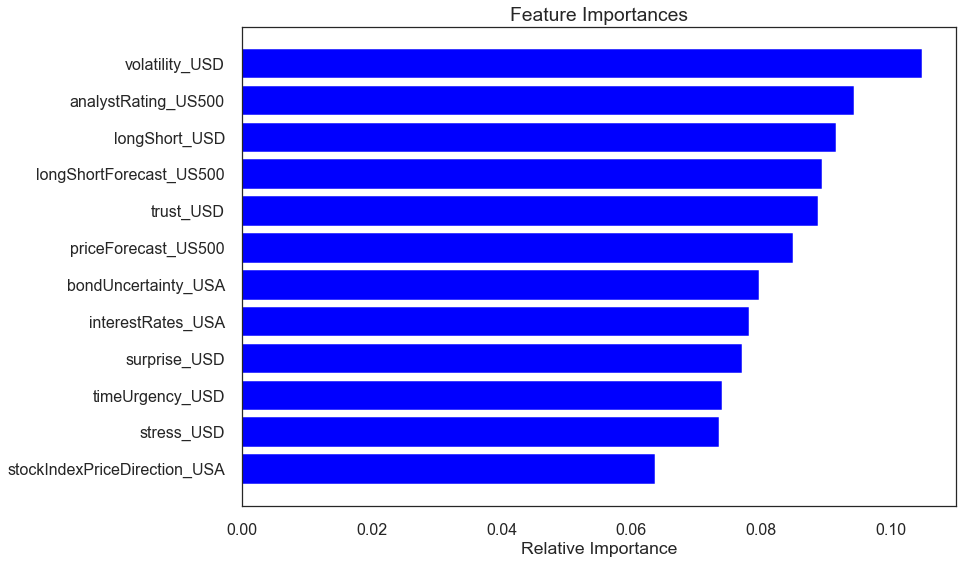

In [112]:
first_model, features = apply_model(train_labels, test_labels, 
                                    X_train_[features8], X_test_[features8], 
                                    'XGB', 'neg_log_loss', sfs=False)

In [ ]:
# only for xgb
plot_tree(first_model, num_trees=1)

In [113]:
# generating meta-labels with previous forecast
tbm_train = tbm_train.reindex(X_train_.index)
tbm_test = tbm_test.reindex(X_test_.index)

tbm_train['side'] = first_model.predict(X_train_[features8])
tbm_test['side'] = first_model.predict(X_test_[features8])

metalabels_train = get_bins(tbm_train, sp500_train['Adj Close'])
metalabels_test = get_bins(tbm_test, sp500_test['Adj Close'])
metalabels_train['label'] = metalabels_train.bin
metalabels_test['label'] = metalabels_test.bin
metalabels_train.dropna(inplace=True)
metalabels_test.dropna(inplace=True)

X_train_ = X_train_.reindex(metalabels_train.index)
X_test_ = X_test_.reindex(metalabels_test.index)
X_train_['side'] = metalabels_train.side
X_test_['side'] = metalabels_test.side

In [114]:
tbm_test.side.unique()

array([-1.,  1.])

In [115]:
metalabels_train.groupby('label').count()

ret  trgt  bin  side
label                      
0.0    504   504  504   504
1.0    984   984  984   984

In [116]:
metalabels_test.groupby('label').count()

ret  trgt  bin  side
label                      
0.0    124   124  124   124
1.0    134   134  134   134

In [117]:
features2.append('side')
features4.append('side')
features5.append('side')
features6.append('side')
features7.append('side')
features8.append('side')
features9.append('side')
all_features = list(X_train.columns)
all_features.append('side')

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 340 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:   17.5s finished


Train best score -0.72
Best parameters: {'base_score': 0.5, 'early_stopping_rounds': 5, 'eta': 0.0005, 'max_depth': 3, 'n_estimators': 40}
Accuracy: 60.47%
AUC: 0.64
Classification report:
              precision    recall  f1-score   support

         0.0       0.66      0.37      0.47       124
         1.0       0.59      0.82      0.68       134

    accuracy                           0.60       258
   macro avg       0.62      0.60      0.58       258
weighted avg       0.62      0.60      0.58       258

Confusion matrix:
[[ 46  78]
 [ 24 110]]


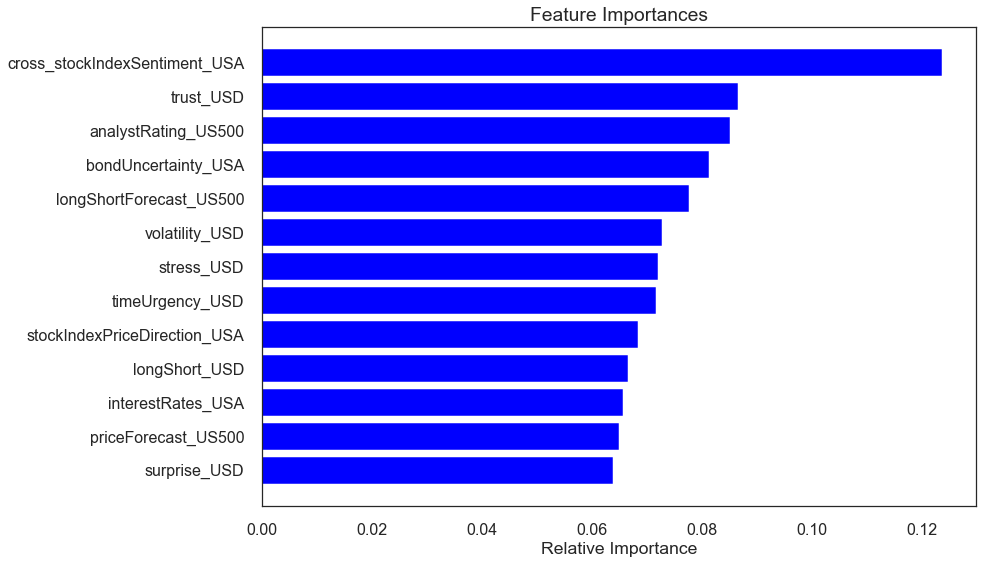

In [118]:
second_model, _ = apply_model(metalabels_train, metalabels_test, 
                              X_train_[features8], X_test_[features8], 
                              'XGB', 'neg_log_loss', sfs=False)

In [169]:
final_predictions = second_model.predict(X_test_[features4]) * X_test_.side

In [170]:
# let's see if we could have possibly made a profit during the covid bear market
final_predictions['2020-02-10': '2020-04-30']

2020-02-12   -0.0
2020-02-20   -0.0
2020-02-24   -0.0
2020-02-25   -0.0
2020-02-26   -0.0
2020-02-28   -0.0
2020-03-03   -1.0
2020-03-04   -0.0
2020-03-05   -1.0
2020-03-06   -0.0
2020-03-10   -0.0
2020-03-11   -1.0
2020-03-12   -0.0
2020-03-13   -1.0
2020-03-16   -1.0
2020-03-17   -1.0
2020-03-23   -0.0
2020-03-25   -1.0
2020-03-27   -1.0
2020-04-02   -0.0
2020-04-07   -1.0
2020-04-10   -0.0
2020-04-20   -0.0
2020-04-22   -1.0
2020-04-27   -0.0
2020-04-30   -0.0
Name: side, dtype: float64

In [173]:
metalabels_test['2020-02-10': '2020-04-30']

ret      trgt  bin  side  label
2020-02-12  0.068361  0.007970  1.0  -1.0    1.0
2020-02-20  0.075611  0.006535  1.0  -1.0    1.0
2020-02-24  0.109469  0.007010  1.0  -1.0    1.0
2020-02-25  0.148588  0.011790  1.0  -1.0    1.0
2020-02-26  0.078633  0.013774  1.0  -1.0    1.0
2020-02-28  0.167224  0.016896  1.0  -1.0    1.0
2020-03-03  0.227847  0.022020  1.0  -1.0    1.0
2020-03-04  0.157883  0.022187  1.0  -1.0    1.0
2020-03-05  0.233863  0.025325  1.0  -1.0    1.0
2020-03-06  0.203228  0.025926  1.0  -1.0    1.0
2020-03-10  0.185381  0.031382  1.0  -1.0    1.0
2020-03-11  0.150890  0.034777  1.0  -1.0    1.0
2020-03-12  0.096966  0.035419  1.0  -1.0    1.0
2020-03-13 -0.060239  0.041798  0.0  -1.0    0.0
2020-03-16  0.062541  0.051065  1.0  -1.0    1.0
2020-03-17 -0.083172  0.058513  0.0  -1.0    0.0
2020-03-23 -0.079712  0.054611  0.0  -1.0    0.0
2020-03-25 -0.086658  0.059292  0.0  -1.0    0.0
2020-03-27 -0.060740  0.057788  0.0  -1.0    0.0
2020-04-02 -0.126638  0.051594  0.0  -1.0    0.0
2020-04-07 -0.059872  0.050419  0.0  -1.0    0.0
2020-04-10 -0.002860  0.044923  0.0  -1.0    0.0
2020-04-20  0.015255  0.036405  1.0  -1.0    1.0
2020-04-22 -0.048192  0.035353  0.0  -1.0    0.0
2020-04-27 -0.032805  0.031555  0.0  -1.0    0.0
2020-04-30  0.040656  0.028584  1.0  -1.0    1.0

In [193]:
# plotting labels to see outcome
figura = make_subplots(specs=[[{"secondary_y": False}]])

dataset = X_test_
dataset['Predictions'] = final_predictions
dataset['Labels'] = test_labels['label']

figura.add_trace(go.Scatter(y=X_test['Adj Close'],
                            x=X_test.index,
                            mode='lines',
                            name='SP500 Close Price'),
                 secondary_y=False,)
figura.add_trace(
    go.Scatter(y=dataset[(dataset.Labels == 1)]['Adj Close'],
               x=dataset[(dataset.Labels == 1)].index,
               mode='markers',
               name='Real Buy',
               marker=dict(size=8, color='#2DCCCD'),
               marker_symbol=19),
               secondary_y=False,)
figura.add_trace(
    go.Scatter(y=dataset[(dataset.Labels == -1)]['Adj Close'],
               x=dataset[(dataset.Labels == -1)].index,
               mode='markers',
               name='Real Sell',
               marker=dict(size=8, color='#D8BE75'),
               marker_symbol=20),
               secondary_y=False,)
figura.add_trace(
    go.Scatter(y=dataset[(dataset.Predictions == 0)]['Adj Close'],
               x=dataset[(dataset.Predictions == 0)].index,
               mode='markers',
               name='Predicted Do Not Take Bet',
               marker=dict(size=5, color='#bfbfbf'),
               marker_symbol=0),
               secondary_y=False,)
figura.add_trace(
    go.Scatter(y=dataset[(dataset.Predictions == 1)]['Adj Close'],
               x=dataset[(dataset.Predictions == 1)].index,
               mode='markers',
               name='Predicted Buy',
               marker=dict(size=8, color='#008000'),
               marker_symbol=5),
               secondary_y=False,)
figura.add_trace(
    go.Scatter(y=dataset[(dataset.Predictions == -1)]['Adj Close'],
               x=dataset[(dataset.Predictions == -1)].index,
               mode='markers',
               name='Predicted Sell',
               marker=dict(size=8, color='#FF0000'),
               marker_symbol=6),
               secondary_y=False,)

figura.update_layout(
    title_text='SP500 Index and predicted positions | Test',
    colorway = bbva)

figura.update_xaxes(rangeslider_visible=True)
figura.update_yaxes(title_text="<b>Price</b>", secondary_y=False)

figura.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        dict(font = dict(color = "black")),
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="2y", step="year", stepmode="backward"),
            dict(count=3, label="3y", step="year", stepmode="backward"),
            dict(count=5, label="5y", step="year", stepmode="backward"),
            dict(step="all"),
        ])
    )
)

figura.update_layout(template='plotly_white', hovermode='x')
iplot(figura)

---

In [ ]:
with plt.style.context('seaborn-poster'):
    plot_importance(gb, max_num_features=35);
# F score
# This is a metric that simply sums up how many times each feature is split on
# It is simply adding the presence of a given feature in all the trees

In [ ]:
importances = gb.get_booster().get_score(importance_type='gain')
sorted(importances.items(), key=lambda item: item[1], reverse=True)

In [ ]:
from sklearn.base import clone 

def drop_col_feat_imp(model, X_train, y_train, random_state = 42):
    
    # clone the model to have the exact same specification as the one initially trained
    model_clone = clone(model)
    # set random_state for comparability
    model_clone.random_state = random_state
    # training and scoring the benchmark model
    model_clone.fit(X_train, y_train)
    benchmark_score = model_clone.score(X_train, y_train)
    
    importances_dict = {}
    # iterating over all columns and storing feature importance (difference between benchmark and new model)
    for col in X_train.columns:
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(X_train.drop(col, axis=1), y_train)
        drop_col_score = model_clone.score(X_train.drop(col, axis=1), y_train)
        importances_dict[col] = [benchmark_score - drop_col_score]
    
    df = pd.DataFrame.from_dict(importances_dict, orient='index', columns=['var'])
    return df

In [ ]:
importances_df = drop_col_feat_imp(gb, X_train_, y_train)

In [ ]:
with plt.style.context('seaborn-poster'):
    importances_df['var'].nlargest(65).sort_values(ascending=True).plot(kind='barh', legend=None);
    plt.xlabel('Gain in log loss');

In [ ]:
features4 = ['earningsForecast_US500',
 'laborDispute_US500',
 'surprise_USD',
 'timeUrgency_USD',
 'longShort_USD',
 'stockIndexPriceForecast_USA',
 'bondSurprise_USA',
 'debtDefault_USA',
 'cross_sentiment_US500',
 'cross_stockIndexSentiment_USA'] #pt sl d 5

features5 = ['conflict_US500',
 'debtDefault_US500',
 'earningsForecast_US500',
 'fundamentalStrength_US500',
 'layoffs_US500',
 'sentiment_USD',
 'violence_USD',
 'surprise_USD',
 'timeUrgency_USD',
 'longShort_USD',
 'priceDirection_USD',
 'priceForecast_USD',
 'priceMomentum_USD',
 'stockIndexPriceDirection_USA',
 'stockIndexPriceForecast_USA',
 'bondOptimism_USA',
 'bondSurprise_USA',
 'cross_sentiment_US500',
 'cross_stockIndexSentiment_USA'] #d5

features6 = ['conflict_US500',
 'debtDefault_US500',
 'earningsForecast_US500',
 'fundamentalStrength_US500',
 'layoffs_US500',
 'sentiment_USD',
 'violence_USD',
 'surprise_USD',
 'timeUrgency_USD',
 'longShort_USD',
 'priceDirection_USD',
 'priceForecast_USD',
 'priceMomentum_USD',
 'stockIndexPriceDirection_USA',
 'stockIndexPriceForecast_USA',
 'bondOptimism_USA',
 'bondSurprise_USA',
 'cross_sentiment_US500',
 'cross_stockIndexSentiment_USA',
 'High', 'Low', 'Open', 'Adj Close', 'ROC', 'RSI', 'Stoch',
 'Williams', 'MACD', 'ADX', 'Close/Open', 'Daily Return',
 'Daily Volatility'] #d5

features7 = ['optimism_US500',
 'stress_US500',
 'surprise_US500',
 'uncertainty_US500',
 'longShort_US500',
 'longShortForecast_US500',
 'analystRating_US500',
 'dividends_US500',
 'laborDispute_US500',
 'managementTrust_US500',
 'stress_USD',
 'emotionVsFact_USD',
 'priceDirection_USD',
 'priceForecast_USD',
 'volatility_USD',
 'stockIndexSentiment_USA',
 'stockIndexPriceDirection_USA',
 'bondDefault_USA',
 'bondPriceForecast_USA',
 'pc1',
 'pc3',
 'cross_sentiment_US500',
 'cross_stockIndexSentiment_USA'] #d2

features8 = ['optimism_US500',
 'stress_US500',
 'surprise_US500',
 'uncertainty_US500',
 'longShort_US500',
 'longShortForecast_US500',
 'analystRating_US500',
 'dividends_US500',
 'laborDispute_US500',
 'managementTrust_US500',
 'stress_USD',
 'emotionVsFact_USD',
 'priceDirection_USD',
 'priceForecast_USD',
 'volatility_USD',
 'stockIndexSentiment_USA',
 'stockIndexPriceDirection_USA',
 'bondDefault_USA',
 'bondPriceForecast_USA',
 'pc1',
 'pc3',
 'cross_sentiment_US500',
 'cross_stockIndexSentiment_USA',
 'High', 'Low', 'Open', 'Adj Close', 'ROC', 'RSI', 'Stoch',
 'Williams', 'MACD', 'ADX', 'Close/Open', 'Daily Return',
 'Daily Volatility'] # d2

In [ ]:
#gb = GradientBoostingClassifier(loss='deviance', n_iter_no_change=10, random_state=42, n_estimators=50)
gb = XGBClassifier(objective='binary:logistic', random_state=1, max_depth=2, n_estimators=100)
gb.fit(X_train_, y_train)
predictions_gb = gb.predict(X_test_)
accuracy = accuracy_score(y_test, predictions_gb)*100
print("Accuracy Extreme Gradient Boosting: %.2f%%" % accuracy)
y_pred_gb = gb.predict_proba(X_test_)[:,1]
print("AUC XGBoost: %.2f" % roc_auc_score(y_test, y_pred_gb))
print(classification_report(y_test, predictions_gb))

rf = RandomForestClassifier(random_state=1, max_depth=2, n_estimators=100)
rf.fit(X_train_, y_train)
predictions_rf = rf.predict(X_test_)
accuracy = accuracy_score(y_test, predictions_rf)*100
print("Accuracy Random Forest: %.2f%%" % accuracy)
y_pred_rf = rf.predict_proba(X_test_)[:,1]
print("AUC Random Forest: %.2f" % roc_auc_score(y_test, y_pred_rf))
print(classification_report(y_test, predictions_rf))

"""
mlp = MLPClassifier(random_state=1, solver='adam', activation='relu', shuffle=False, early_stopping=True)
mlp.fit(X_train_, y_train)
predictions = mlp.predict(X_test_)
accuracy = accuracy_score(y_test, predictions)*100
print("Accuracy Multilayer Perceptron: %.2f%%" % accuracy)
y_pred = mlp.predict_proba(X_test_)[:,1]
print("AUC MLP: %.2f" % roc_auc_score(y_test, y_pred))
print(classification_report(y_test, predictions))"""

"""
knn = KNeighborsClassifier()
knn.fit(StandardScaler().fit_transform(X_train_), y_train)
predictions = knn.predict(X_test_)
accuracy = accuracy_score(y_test, predictions)*100
print("Accuracy KNN: %.2f%%" % accuracy)
y_pred = knn.predict_proba(X_test_)[:,1]
print("AUC KNN: %.2f" % roc_auc_score(y_test, y_pred))
print(classification_report(y_test, predictions))"""

thresholds = np.sort(gb.feature_importances_)
for thresh in np.unique(thresholds):
    # select features using threshold
    selection = SelectFromModel(gb, threshold=thresh, prefit=True)
    select_X_train_ = selection.transform(X_train_)
    # train model
    selection_model = XGBClassifier(objective='binary:logistic', eval_metric='error', 
                                    n_estimators=100, max_depth=2, random_state=1,
                                    importance_type='gain')
    selection_model.fit(select_X_train_, y_train)
    # eval model
    select_X_test_ = selection.transform(X_test_)
    predictions = selection_model.predict(select_X_test_)
    y_pred = selection_model.predict_proba(select_X_test_)[:,1]
    accuracy = accuracy_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%, AUC: %.2f" % (thresh, select_X_train_.shape[1], 
                                                             accuracy*100.0, 
                                                             roc_auc_score(y_test, y_pred)))

In [ ]:
# en caso de que test comenzara en el año 2000 y se seleccionase una porción de cada mes
"""# case for sequential training, month by month
recalc_dates = X_train.resample('M', level='Date').mean().index.values[:-1]
recalc_dates = [date[:10] for date in np.datetime_as_string(recalc_dates)]

models = pd.Series(index=recalc_dates)
for date in recalc_dates:
    X_train_ = X_train.loc[:date]
    y_train_ = y_train.loc[:date]
    model = XGBClassifier(objective='binary:logistic', n_estimators=40, max_depth=2, random_state=42)
    model.fit(X_train_, y_train_)
    models.loc[date] = model
"""